Load the Boston Housing dataset.

In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We don't have a very big dataset here... it's just 506 rows, total, 13 features.

In [3]:
print("Train data dimensions:",train_data.shape)
print("Test data dimensions:",test_data.shape)
print(train_targets) # these are home prices in $1,000s of dollars (in the 70s that was a lot of money)

Train data dimensions: (404, 13)
Test data dimensions: (102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3 

And, let's define our simple network. We are going to define a simple function that re-specifies our model and compiles it. We're doing this because we will use this inside a nested loop that implements k-fold cross-validation. This is something you've probably already learned in other classes, but when your sample is small, it's generally not a good idea to rely on single random holdout for model evaluation.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
      #layers.Dropout(rate=0.5),
      #layers.BatchNormalization(), # This whitens the inputs to the next layer (de-mean, divide by SD, which can help with overfitting)
      layers.Dense(8, activation="relu"),
      #layers.Dropout(0.5),
      #layers.BatchNormalization(),
      layers.Dense(4, activation="relu"),
      layers.Dense(1)
])

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

This dataset is tiny, so cross validation is probably a good idea.

In [5]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

k = 4 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_mae_histories = []
all_fold_train_mae_histories = [] # Initialize the list to store training MAE histories

for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
    print(f"\nProcessing fold #{fold + 1}")

    # Split data for current fold
    partial_train_data = train_data[train_index]
    partial_train_targets = train_targets[train_index]
    val_data = train_data[val_index]
    val_targets = train_targets[val_index]

    # Build a fresh model (compiled) for each fold
    model = build_model()

    # Train the model silently
    history = model.fit(
        partial_train_data, partial_train_targets,
        epochs=20,
        batch_size=1,
        verbose=1 # Set verbose to 1 to see training output.
    )

    # Append training MAE history for the current fold
    all_fold_train_mae_histories.append(history.history['mae'])

    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    print(f"Validation MAE for fold {fold + 1}: {val_mae:.4f}")
    all_mae_histories.append(val_mae)

print(f"\nAll validation MAEs: {all_mae_histories}")
print(f"Average validation MAE: {np.mean(all_mae_histories):.4f}")
print(f"\nAll training MAE histories (first 5 values for each fold): {[h[:5] for h in all_fold_train_mae_histories]}")


Processing fold #1
Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1104.3192 - mae: 26.6587
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 96.2664 - mae: 7.1094
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 73.5515 - mae: 6.0903
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.5556 - mae: 5.3838
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.9235 - mae: 5.7409
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.1958 - mae: 5.2664
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.3269 - mae: 5.2488
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.6343 - mae: 5.2075
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52.7842 - mae: 5.0588
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 46.4061 - mae: 4.9179
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.2157 - mae: 5.1349
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.2535 - ma

Plot average MAE over training steps across the k folds.

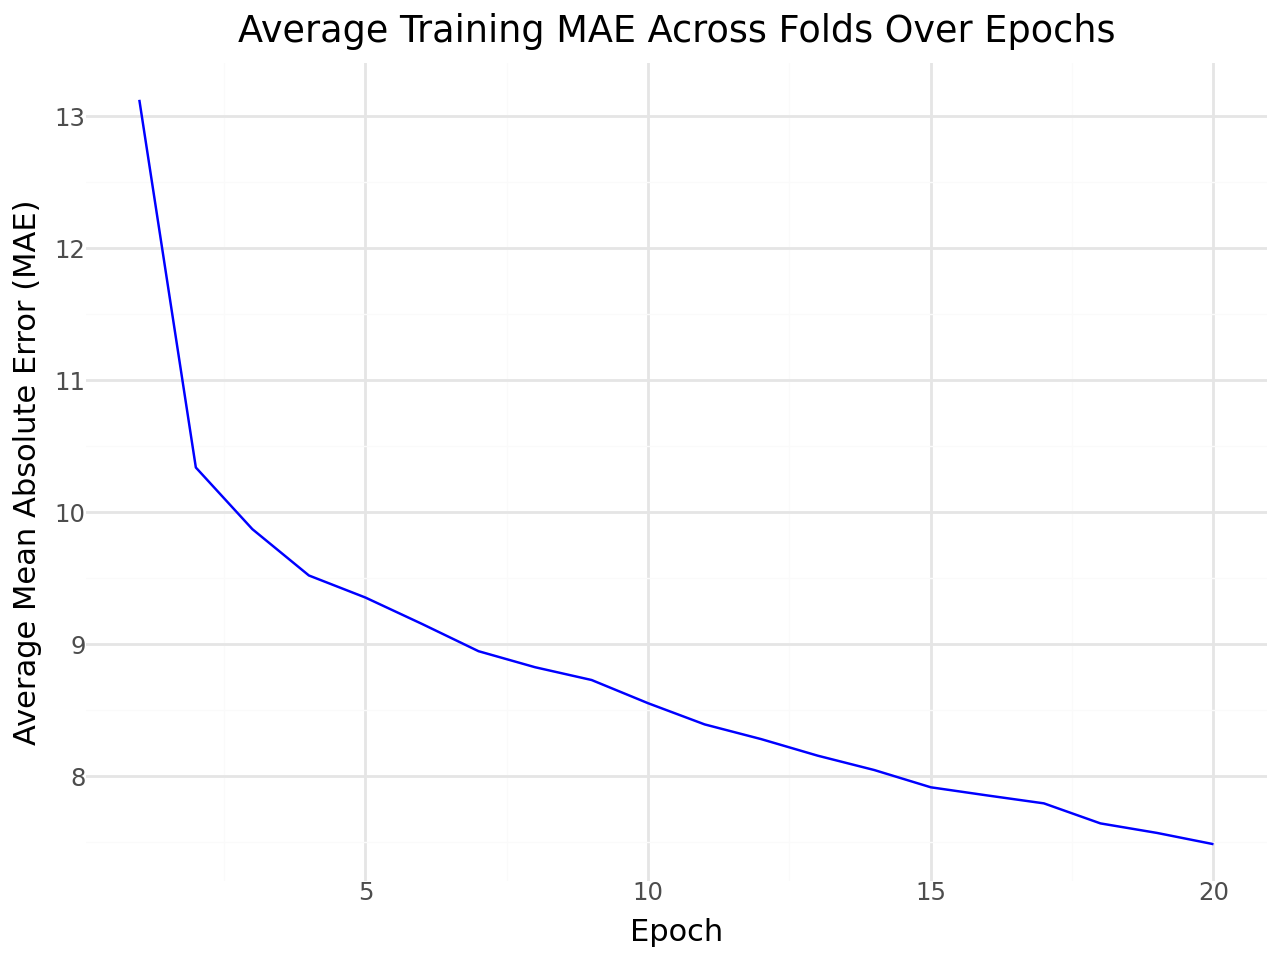

In [10]:
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# Convert all_fold_train_mae_histories to a DataFrame for easier plotting
# First, ensure all lists are of the same length, if not, pad with NaN
# In this case, all epochs are 100, so lengths should be consistent.
max_len = max(len(h) for h in all_fold_train_mae_histories)

# Pad histories (though likely not needed if all trained for same epochs)
padded_histories = [h + [np.nan] * (max_len - len(h)) for h in all_fold_train_mae_histories]

# Convert to numpy array for mean calculation
mae_array = np.array(padded_histories)

# Calculate the average MAE across folds for each epoch
average_mae_per_epoch = np.nanmean(mae_array, axis=0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'epoch': range(1, max_len + 1),
    'average_mae': average_mae_per_epoch
})

# Create the plot using plotnine
(ggplot(plot_df, aes(x='epoch', y='average_mae'))
 + geom_line(color='blue')
 + labs(title='Average Training MAE Across Folds Over Epochs',
        x='Epoch',
        y='Average Mean Absolute Error (MAE)')
 + theme_minimal())

We can safely retrain on the entire training sample through epoch 20 without overfitting.